# Footskate Cleanup for Motion Capture Editing

by Lucas Kovar, Michael Gleicher, John Schreiner  
Siggraph 2002 

Notebook by Jerome Eippers, 2024

In [1]:
%matplotlib widget
import ipyanimlab as lab
import numpy as np
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt

viewer = lab.Viewer(move_speed=5, width=1280, height=720)

In [2]:
character = viewer.import_usd_asset('AnimLabSimpleMale.usd')

In [13]:
target = viewer.create_asset(
    vertices = np.asarray([[9.37, 0.58, -6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [3.58, 0.58, -11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-3.58, 0.58, -11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-9.37, 0.58, -6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-11.58, 0.58, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-9.37, 0.58, 6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-3.58, 0.58, 11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [3.58, 0.58, 11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [9.37, 0.58, 6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [11.58, 0.58, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.58, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]], dtype=np.float32),
    indices = np.asarray([[1, 2, 10], [3, 4, 10], [5, 6, 10], [7, 8, 10], [9, 0, 10]], dtype=np.int16)
)

## Prepare the data

We add a few bones in the skeleton to add a heel and a ball at each foot.

In [4]:
character.add_bone('LeftHeel', np.array([1,0,0,0]), np.array([9.2,0,-12]), 'LeftFoot')
character.add_bone('LeftBall', np.array([1,0,0,0]), np.array([14.5,0,8.22]), 'LeftFoot')
character.add_bone('RightHeel', np.array([1,0,0,0]), np.array([-9.2,0,-12]), 'RightFoot')
character.add_bone('RightBall', np.array([1,0,0,0]), np.array([-14.5,0,8.22]), 'RightFoot')

contact_distance = np.linalg.norm(np.array([9.2,0,-12]) - np.array([14.5,0,8.22]))
left_heel = character.bone_index('LeftHeel')
left_ball = character.bone_index('LeftBall')
right_heel = character.bone_index('RightHeel')
right_ball = character.bone_index('RightBall')
left_foot = character.bone_index('LeftFoot')
right_foot = character.bone_index('RightFoot')

contact_indices = np.asarray([left_heel, left_ball, right_heel, right_ball], dtype=np.int8)

In [5]:
# def render(x, z):
    
#     character.update_initial_bone('LeftHeel', np.array([1,0,0,0]), np.array([x,0,z]), True)
    
#     viewer.begin_display()
#     viewer.draw_ground()
#     viewer.draw_mesh(character)
#     viewer.end_display()

#     viewer.disable(depth_test=True)

#     viewer.draw_axis(character.global_bones(), 5)
#     viewer.draw_lines(character.global_skeleton_lines())

#     viewer.execute_commands()
    
# interact(
#     render, 
#     x=widgets.FloatSlider(min=-30, max=30, step=0.01),
#     z=widgets.FloatSlider(min=-30, max=30, step=0.01))
# viewer

Read the data on our skeleton, and read the original data to extract where the feet should have been

In [9]:
animmap = lab.AnimMapper(character, keep_translation=False, root_motion=True)
animation = lab.import_bvh('../../resources/lafan1/bvh/aiming1_subject1.bvh', anim_mapper=animmap)

animmap = lab.AnimMapper(character, keep_translation=True, root_motion=True)
original = lab.import_bvh('../../resources/lafan1/bvh/aiming1_subject1.bvh', anim_mapper=animmap)

frame_count = animation.quats.shape[0]
bone_count = character.bone_count()

In [10]:
# offset the animation upward
animation.pos[:, character.bone_index('Hips'), 1] += 4

## Find feet contacts timing

Using the original motion we check when the heel and balls are under a certain speed threshold, and we assume that the foot is planted.  
We then smooth that signal a little to avoir having 1, 2 or 3 frames small unplanted foot.

In [11]:
ogquats, ogpos = lab.utils.quat_fk(original.quats, original.pos, original.parents)
agquats, agpos = lab.utils.quat_fk(animation.quats, animation.pos, animation.parents)

contacts = np.zeros([frame_count, 4], dtype=np.bool_)
contacts[:, :2], contacts[:, 2:] = lab.utils.extract_feet_contacts(ogpos, [left_heel, left_ball], [right_heel, right_ball],  0.04)

# smooth out a little the signal ( we keep the signal on if it switch off for one or 2 frames )
for frame in range(2, frame_count-2):
    for c in range(4):
        contacts[frame, c] = contacts[frame, c] or (contacts[frame-2, c] and contacts[frame+2, c])
    
for frame in range(1, frame_count-1):
    for c in range(4):
        contacts[frame, c] = contacts[frame, c] or (contacts[frame-1, c] and contacts[frame+1, c])


interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

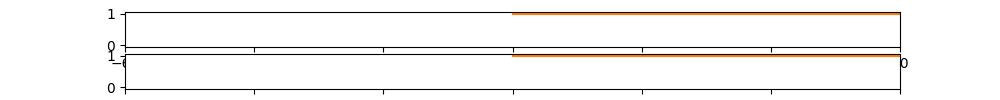

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,1))
ax1.plot(contacts[:, 0])
ax1.plot(contacts[:, 1])
ax2.plot(contacts[:, 2])
ax2.plot(contacts[:, 3])

def render(frame, ori):
    
    anim = original if ori else animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    
    contacts_matrices = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(4, axis=0)
    for c in range(4):
        if contacts[frame, c]:
            contacts_matrices[c, [0,2], 3] = ogpos[frame, contact_indices[c], [0,2]]
    
    viewer.draw(target, contacts_matrices)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_axis(character.world_skeleton_xforms(a), 5)
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    viewer.execute_commands()
    
    ax1.set_xlim([frame-60,frame+60])
    ax2.set_xlim([frame-60,frame+60])
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1),
    ori = widgets.Checkbox())
viewer

## Constraints Positions

To compute the contact position we check for each heel and ball if it was already constrained the previous frame. If it was, we keep the same constraint. If it was not, we average the position over the next L1 number of frames and project it on the ground. If the other part of the foot was already constrained (for example if the heel was constrained but not the ball) we realign the current so the distance between heel and ball is correct. 

In [14]:
L1 = 10 #As per the paper experiments
constraint_positions_buffer = np.zeros((frame_count, 4, 3), dtype=np.float32)


def contact_position(frame, index, other_index, other_frame):
    """
        frame : the frame to compute
        index : the index of the contact we compute
        other_index : the index of the other contact of the same foot
        other_frame : the frame at wich we want to check if we already have a contact computed
    """
    avr = np.zeros(3, dtype=np.float32)
    if contacts[frame, index] :
        
        # check if the previous frame was already constrained
        if frame > 0 and contacts[frame-1, index]:
            constraint_positions_buffer[frame, index] = constraint_positions_buffer[frame-1, index]
            
        else:
            # else average the positions of the next L1 frames and project on ground
            count = 0
            for i in range(L1):
                if frame+i < frame_count:
                    if contacts[frame+i, index]:
                        avr += agpos[frame+i, contact_indices[index], :]
                        count += 1
                    else:
                        break
            avr /= count
            avr[1] = 0

            # ensure rigid foot by forcing the distance between both contact points of the same foot
            # we will call this in order so if we check the ball we check if the heel is already constrained on the same frame
            # or if we check the heel we will check if the ball was already constrained the previous frame
            if other_frame >= 0:
                if contacts[other_frame, other_index]:
                    vect = avr - constraint_positions_buffer[other_frame, other_index]
                    avr = constraint_positions_buffer[other_frame, other_index] + vect / np.linalg.norm(vect) * contact_distance
                    
            constraint_positions_buffer[frame, index] = avr
                    

for frame in range(frame_count):
    contact_position(frame, 0, 1, frame-1)
    contact_position(frame, 1, 0, frame)
    contact_position(frame, 2, 3, frame-1)
    contact_position(frame, 3, 2, frame)
    

In [16]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    
    contacts = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(4, axis=0)
    contacts[:, :3, 3] = constraint_positions_buffer[frame, :, :]
    
    viewer.draw(target, contacts)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_axis(character.world_skeleton_xforms(a), 5)
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-16.199999999999967, camera_pos=[-485.17494660140756,…

## Ankle Position and Orientation

In [18]:
L2 = 8
ankle_rotation_buffer = np.array([[1, 0, 0, 0],[1, 0, 0, 0]], dtype=np.float32)[np.newaxis, :].repeat(frame_count, axis=0)
ankle_position_buffer = np.zeros([frame_count, 2, 3], dtype=np.float32)

def compute_double_constrained_ankle(frame, heel, ball, foot, buffer_index):
    """
    frame : the frame to compute
    heel : the index of the heel in the contact buffer
    ball : the index of the ball in the contact buffer
    foot : the index of the foot in the character
    buffer_index : the index in the buffers ( left or right = 0 or 1 )
    """
    
    # double constraint
    if contacts[frame, heel] and contacts[frame, ball]:
        
        # compute the quaternion that rotates the heel-ball vector from the original position to the constrained position
        # with a up vector purely vertical
        quat = lab.utils.quat_between(
            agpos[frame, contact_indices[ball], :] - agpos[frame, contact_indices[heel], :], 
            constraint_positions_buffer[frame, ball, :] - constraint_positions_buffer[frame, heel, :], 
            np.array([0,1,0], dtype=np.float32)
        )
        
        # compute the position of the hankle knowing the new orientation and the heel position
        gquat= lab.utils.quat_mul(quat, agquats[frame, foot, :])
        gpos = agpos[frame, foot, :] + lab.utils.quat_mul_vec(gquat, animation.pos[0,  contact_indices[heel], :])
        
        ankle_rotation_buffer[frame, buffer_index] = quat
        ankle_position_buffer[frame, buffer_index] = constraint_positions_buffer[frame, heel, :] - gpos
        
        
def compute_single_constrained_ankle(frame, heel, ball, foot, buffer_index):
    """
    frame : the frame to compute
    heel : the index of the heel in the contact buffer
    ball : the index of the ball in the contact buffer
    foot : the index of the foot in the character
    buffer_index : the index in the buffers ( left or right = 0 or 1 )
    """
    
    # check if we are singly constained
    if (contacts[frame, heel] and contacts[frame, ball]) == False and ((contacts[frame, heel] or contacts[frame, ball])):
        
        # store if we are heel or ball constrained
        cnst_index = heel if contacts[frame, heel] else ball
        
        # check L2 frame before the current frame to see if we encounter a doubly constrained.
        back_hit = -1
        local_quat = np.array([1,0,0,0], dtype=np.float32)
        
        for f in range(L2):
            # do we hit a double constrained ?
            if frame-f >= 0 and contacts[frame-f, heel] and contacts[frame-f, ball]:
                
                # lerp the orientation computed by the doubly constrained
                back_hit = f
                alpha = (f+1.0)/(L2+1.0)
                alpha = 2*alpha*alpha*alpha - 3*alpha*alpha + 1
                local_quat = lab.utils.quat_slerp(np.array([[1,0,0,0]], dtype=np.float32), ankle_rotation_buffer[frame-f, buffer_index][np.newaxis,:], alpha)[0]
                break
                
            # if we hit a free contact we stop searching
            if frame-f >= 0 and contacts[frame, cnst_index] == False:
                break
                
        # check L2 frame after the current frame to see if we encounter a doubly constrained.
        front_hit = -1
        for f in range(L2):
            if frame+f < frame_count and contacts[frame+f, heel] and contacts[frame+f, ball]:
                
                # lerp the orientation computed by the doubly constrained
                front_hit = f
                alpha = (f+1.0)/(L2+1.0)
                alpha = 2*alpha*alpha*alpha - 3*alpha*alpha + 1
                front_quat = lab.utils.quat_slerp(np.array([[1,0,0,0]], dtype=np.float32), ankle_rotation_buffer[frame+f, buffer_index][np.newaxis,:], 1.0-alpha)[0]

                # if we had already computed a lerp with the backward it, we will slerp the 2 together
                if back_hit > -1:
                    alpha = (back_hit+1.0)/(back_hit+front_hit+1.0)
                    local_quat = lab.utils.quat_slerp(local_quat[np.newaxis,:], front_quat[np.newaxis,:], alpha)[0]
                else:
                    local_quat = front_quat
                    
            # if we hit a free contact we stop searching
            if frame-f >= 0 and contacts[frame+f, cnst_index] == False:
                break
                
        # compute position
        gquat = lab.utils.quat_mul(local_quat, agquats[frame, foot, :])
        gpos = agpos[frame, foot, :] + lab.utils.quat_mul_vec(gquat, animation.pos[0,  contact_indices[cnst_index], :])
        
        ankle_rotation_buffer[frame, buffer_index] = local_quat
        ankle_position_buffer[frame, buffer_index] = constraint_positions_buffer[frame, cnst_index, :] - gpos
        

for frame in range(frame_count):
    compute_double_constrained_ankle(frame, 0, 1, left_foot, 0)
    compute_double_constrained_ankle(frame, 2, 3, right_foot, 1)
    
for frame in range(frame_count):
    compute_single_constrained_ankle(frame, 0, 1, left_foot, 0)
    compute_single_constrained_ankle(frame, 2, 3, right_foot, 1)
    

In [22]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    
    contacts = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(4, axis=0)
    contacts[:, :3, 3] = constraint_positions_buffer[frame, :, :]
    
    viewer.draw(target, contacts)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 0, :], agquats[frame, character.bone_index('LeftFoot'), :])
    gpos = agpos[frame, character.bone_index('LeftFoot'), :] + ankle_position_buffer[frame, 0, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 1, :], agquats[frame, character.bone_index('RightFoot'), :])
    gpos = agpos[frame, character.bone_index('RightFoot'), :] + ankle_position_buffer[frame, 1, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=300
                         )
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-16.199999999999967, camera_pos=[-485.17494660140756,…

## Root Position

In [24]:
L3 = 8
root_buffer = np.zeros([frame_count, 3], dtype=np.float32)
leg_length = animation.pos[0,character.bone_index('LeftLeg'),0] + animation.pos[0,character.bone_index('LeftFoot'),0]

def compute_root_offset(left_hips, right_hips, left_ankle, right_ankle, leg_length):
    def _project(root, ankle):
        vector = ankle - root
        dist = np.sqrt(np.sum(vector*vector))
        if dist > leg_length:
            return True, (vector/dist)*(dist-leg_length)
        else:
            return False, np.zeros([3], dtype=np.float32)
        
    left, left_offset = _project(left_hips, left_ankle)
    right, right_offset = _project(right_hips, right_ankle)
    
    if left and not right:
        return left_offset
    
    if right and not left:
        return right_offset
    
    if left and right:
        current_offset = left_offset
        for i in range(5):
            loop, offset = _project(right_hips + current_offset, right_ankle)
            if not loop:
                return current_offset
            current_offset += offset
            loop, offset = _project(left_hips + current_offset, left_ankle)
            if not loop:
                return current_offset
            current_offset += offset
        return current_offset
    return np.zeros([3], dtype=np.float32)
        
_temp_root_buffer = np.zeros([frame_count, 3], dtype=np.float32)
for frame in range(frame_count):
    if np.any(contacts[frame, :]):
        _temp_root_buffer[frame, :] = compute_root_offset(
            agpos[frame, character.bone_index('LeftUpLeg'), :],
            agpos[frame, character.bone_index('RightUpLeg'), :],
            agpos[frame, character.bone_index('LeftFoot'), :]+ ankle_position_buffer[frame, 0, :],
            agpos[frame, character.bone_index('RightFoot'), :]+ ankle_position_buffer[frame, 1, :],
            leg_length
        )
        
for frame in range(frame_count):
    if np.any(contacts[frame, :]):
        count = 0
        value = np.zeros([3], dtype=np.float32)
        for f in range(-L3+1,L3):
            if frame+f >= 0 and frame+f < frame_count:
                value += _temp_root_buffer[frame+f, :]
                count +=1
        root_buffer[frame, :] = value/count
    

In [25]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    
    contacts = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(4, axis=0)
    contacts[:, :3, 3] = constraint_positions_buffer[frame, :, :]
    
    viewer.draw(target, contacts)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 0, :], agquats[frame, character.bone_index('LeftFoot'), :])
    gpos = agpos[frame, character.bone_index('LeftFoot'), :] + ankle_position_buffer[frame, 0, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 1, :], agquats[frame, character.bone_index('RightFoot'), :])
    gpos = agpos[frame, character.bone_index('RightFoot'), :] + ankle_position_buffer[frame, 1, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = agquats[frame, character.bone_index('Hips'), :]
    gpos = agpos[frame, character.bone_index('Hips'), :] + root_buffer[frame, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-16.199999999999967, camera_pos=[-485.17494660140756,…

## Compute IK

In [27]:
import copy

def compute_final_animation():
    local_anim = copy.deepcopy(animation)
    local_anim.pos[:, character.bone_index('Hips'), :] += root_buffer
    gq, gp = lab.utils.quat_fk(local_anim.quats, local_anim.pos, local_anim.parents)
    
    # prepare sizes
    len1 = animation.pos[0, character.bone_index('LeftLeg'), 0]
    len2 = animation.pos[0, character.bone_index('LeftFoot'), 0]
    l1l2_2 = np.array([len1 * len2 *2.0], dtype=np.float32).repeat(frame_count)
    l1_l2 = np.array([len1*len1 + len2*len2], dtype=np.float32).repeat(frame_count)
    
    # compute left leg angle
    #------------------------
    ankle_vector = agpos[:, character.bone_index('LeftFoot'), :] + ankle_position_buffer[:, 0, :] - gp[:, character.bone_index('LeftUpLeg'), :]
    ankle_dist = np.sum(ankle_vector*ankle_vector, axis=-1)
    ankle_arccos = (l1_l2 - ankle_dist)/l1l2_2

    # knee damping using a polynomial to ease out the over stretch
    ankle_arccos = -.037037*ankle_arccos**7 + .0314815*ankle_arccos**6 + .0374074*ankle_arccos**5 - .0260185*ankle_arccos**4 - .0114815*ankle_arccos**3 + .00453704*ankle_arccos**2 + 1.00111*ankle_arccos

    # apply the rotation on the knee
    _angle = (np.pi - np.arccos(np.maximum(np.array(-1, dtype=np.float32).repeat(frame_count), ankle_arccos)))/2.0
    local_anim.quats[:, character.bone_index('LeftLeg'), 0] = np.cos(-_angle)
    local_anim.quats[:, character.bone_index('LeftLeg'), 3] = np.sin(-_angle)
    
    # recompute the global position of the foot
    local_anim.quats = lab.utils.quat_normalize(local_anim.quats)
    gq, gp = lab.utils.quat_fk(local_anim.quats, local_anim.pos, local_anim.parents)
    
    # rotate the leg (must be done on global position, then convert back on local)
    rot = lab.utils.quat_between(gp[:, character.bone_index('LeftFoot'), :] - gp[:, character.bone_index('LeftUpLeg'), :], ankle_vector)
    gq[:, character.bone_index('LeftUpLeg'), :] = lab.utils.quat_mul(rot, gq[:, character.bone_index('LeftUpLeg'), :])
    local_anim.quats[:, character.bone_index('LeftUpLeg'), :] = lab.utils.quat_ik(gq, gp, local_anim.parents)[0][:, character.bone_index('LeftUpLeg'), :]

    # recompute the global position
    local_anim.quats = lab.utils.quat_normalize(local_anim.quats)
    gq, gp = lab.utils.quat_fk(local_anim.quats, local_anim.pos, local_anim.parents)
    
    # force the foot on the constraint in global and convert in local
    gq[:, character.bone_index('LeftFoot'), :] = lab.utils.quat_mul(ankle_rotation_buffer[:, 0, :], agquats[:, character.bone_index('LeftFoot'), :])
    gp[:, character.bone_index('LeftFoot'), :] = agpos[:, character.bone_index('LeftFoot'), :] + ankle_position_buffer[:, 0, :]
    lq, lp = lab.utils.quat_ik(gq, gp, local_anim.parents)
    local_anim.quats[:, character.bone_index('LeftFoot'), :] = lq[:, character.bone_index('LeftFoot'), :]
    local_anim.pos[:, character.bone_index('LeftFoot'), :] = lp[:, character.bone_index('LeftFoot'), :]
    
    
    # compute right leg angle
    #------------------------
    ankle_vector = agpos[:, character.bone_index('RightFoot'), :] + ankle_position_buffer[:, 1, :] - gp[:, character.bone_index('RightUpLeg'), :]
    ankle_dist = np.sum(ankle_vector*ankle_vector, axis=-1)
    ankle_arccos = (l1_l2 - ankle_dist)/l1l2_2
    
    # knee damping using a polynomial to ease out the over stretch
    ankle_arccos = -.037037*ankle_arccos**7 + .0314815*ankle_arccos**6 + .0374074*ankle_arccos**5 - .0260185*ankle_arccos**4 - .0114815*ankle_arccos**3 + .00453704*ankle_arccos**2 + 1.00111*ankle_arccos
    
    # apply the rotation on the knee
    _angle = (np.pi - np.arccos(np.maximum(np.array(-1, dtype=np.float32).repeat(frame_count), ankle_arccos)))/2.0
    local_anim.quats[:, character.bone_index('RightLeg'), 0] = np.cos(-_angle)
    local_anim.quats[:, character.bone_index('RightLeg'), 3] = np.sin(-_angle)
    
    # recompute the global position of the foot
    local_anim.quats = lab.utils.quat_normalize(local_anim.quats)
    gq, gp = lab.utils.quat_fk(local_anim.quats, local_anim.pos, local_anim.parents)
    
    # rotate the leg (must be done on global position, then convert back on local)
    rot = lab.utils.quat_between(gp[:, character.bone_index('RightFoot'), :] - gp[:, character.bone_index('RightUpLeg'), :], ankle_vector)
    gq[:, character.bone_index('RightUpLeg'), :] = lab.utils.quat_mul(rot, gq[:, character.bone_index('RightUpLeg'), :])
    local_anim.quats[:, character.bone_index('RightUpLeg'), :] = lab.utils.quat_ik(gq, gp, local_anim.parents)[0][:, character.bone_index('RightUpLeg'), :]

    # recompute the global position
    local_anim.quats = lab.utils.quat_normalize(local_anim.quats)
    gq, gp = lab.utils.quat_fk(local_anim.quats, local_anim.pos, local_anim.parents)
    
    # force the foot on the constraint in global and convert in local
    gq[:, character.bone_index('RightFoot'), :] = lab.utils.quat_mul(ankle_rotation_buffer[:, 1, :], agquats[:, character.bone_index('RightFoot'), :])
    gp[:, character.bone_index('RightFoot'), :] = agpos[:, character.bone_index('RightFoot'), :] + ankle_position_buffer[:, 1, :]
    lq, lp = lab.utils.quat_ik(gq, gp, local_anim.parents)
    local_anim.quats[:, character.bone_index('RightFoot'), :] = lq[:, character.bone_index('RightFoot'), :]
    local_anim.pos[:, character.bone_index('RightFoot'), :] = lp[:, character.bone_index('RightFoot'), :]
    
    
    return local_anim

solved_animation = compute_final_animation()

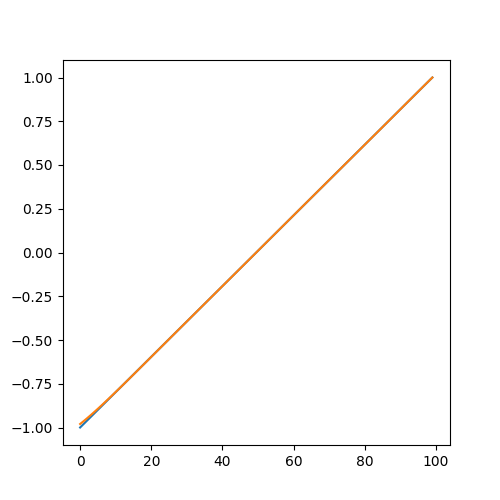

In [18]:
#knee damping polynomial

x = np.linspace(-1, 1, 100)
fig, (ax) = plt.subplots(1, 1, figsize=(5,5))
ax.plot(x)
z = -.037037*x**7 + .0314815*x**6 + .0374074*x**5 - .0260185*x**4 - .0114815*x**3 + .00453704*x**2 + 1.00111*x

ax.plot(z)

In [29]:
def render(frame, solved=True):
    
    anim = solved_animation if solved else animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    
    contacts = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(4, axis=0)
    contacts[:, :3, 3] = constraint_positions_buffer[frame, :, :]
    
    viewer.draw(target, contacts)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 0, :], agquats[frame, character.bone_index('LeftFoot'), :])
    gpos = agpos[frame, character.bone_index('LeftFoot'), :] + ankle_position_buffer[frame, 0, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 1, :], agquats[frame, character.bone_index('RightFoot'), :])
    gpos = agpos[frame, character.bone_index('RightFoot'), :] + ankle_position_buffer[frame, 1, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = agquats[frame, character.bone_index('Hips'), :]
    gpos = agpos[frame, character.bone_index('Hips'), :] + root_buffer[frame, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    viewer.execute_commands()
    
    
    
interact(
    render, 
    frame=lab.Timeline(max=500
                         ),
    solved=widgets.Checkbox(value=True)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-16.199999999999967, camera_pos=[-485.17494660140756,…

## Final Processing

In [30]:
L4 = 10

for frame in range(frame_count):
    # if there is no constraints we can check if we have to smooth the hips
    if not np.any(contacts[frame,:]):
        pos = np.array([0,0,0], dtype=np.float32)
        
        # backward
        backhit = -1
        for f in range(L4):
            if frame-f >= 0 and np.any(contacts[frame,:]):
                backhit = f
                alpha = (f+1.0)/(L2+1.0)
                alpha = 2*alpha*alpha*alpha - 3*alpha*alpha + 1
                pos = root_buffer[frame-f]*(alpha)
                break
                
        # forward
        for f in range(L4):
            if frame+f < frame_count and np.any(contacts[frame,:]):
                alpha = (f+1.0)/(L2+1.0)
                alpha = 2*alpha*alpha*alpha - 3*alpha*alpha + 1
                fpos = root_buffer[frame+f]*(alpha)
                if backhit > -1:
                    alpha = (backhit+1.0)/(backhit+f+1.0)
                    pos = pos*(1.0-alpha) + fpos*(alpha)
                else:
                    pos = fpos
                break
                
        root_buffer[frame] = pos
        
    def _ankle(foot_contacts, rotation_offsets, position_offsets):
        if not np.any(foot_contacts[frame,:]):
            local_quat = np.array([1,0,0,0], dtype=np.float32)
            local_pos = np.array([0,0,0], dtype=np.float32)
            
            # backward
            back_hit = -1
            for f in range(L4):
                if frame-f >= 0 and np.any(foot_contacts[frame-f, :]):
                    xx = position_offsets[frame-f]
                    back_hit = f
                    alpha = (f+1.0)/(L4+1.0)
                    alpha = 2*alpha*alpha*alpha - 3*alpha*alpha + 1
                    local_quat = lab.utils.quat_slerp(np.array([[1,0,0,0]], dtype=np.float32), rotation_offsets[frame-f][np.newaxis,:], alpha)[0]
                    local_pos = position_offsets[frame-f]*(alpha)
                    break

            # forward
            front_hit = -1
            for f in range(L4):
                if frame+f < frame_count and np.any(foot_contacts[frame+f, :]):
                    yy = position_offsets[frame+f]
                    front_hit = f
                    alpha = (f+1.0)/(L4+1.0)
                    alpha = 2*alpha*alpha*alpha - 3*alpha*alpha + 1
                    front_quat = lab.utils.quat_slerp(np.array([[1,0,0,0]], dtype=np.float32), rotation_offsets[frame+f][np.newaxis,:], alpha)[0]
                    front_pos = position_offsets[frame+f]*(alpha)

                    if back_hit > -1:
                        alpha = (back_hit+1.0)/(back_hit+front_hit+1.0)
                        local_quat = lab.utils.quat_slerp(local_quat[np.newaxis,:], front_quat[np.newaxis,:], alpha)[0]
                        local_pos = local_pos*(1-alpha) + front_pos*(alpha)
                    else:
                        local_quat = front_quat
                        local_pos = front_pos
                    break
            return local_quat, local_pos
        return rotation_offsets[frame], position_offsets[frame]
    
    ankle_rotation_buffer[frame, 0, :], ankle_position_buffer[frame, 0, :] = _ankle(contacts[:, :2], ankle_rotation_buffer[:,0,:], ankle_position_buffer[:,0,:])
    ankle_rotation_buffer[frame, 1, :], ankle_position_buffer[frame, 1, :] = _ankle(contacts[:, 2:], ankle_rotation_buffer[:,1,:], ankle_position_buffer[:,1,:])

solved_animation = compute_final_animation()

In [32]:
def render(frame, solved=True):
    
    anim = solved_animation if solved else animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    
    contacts = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(4, axis=0)
    contacts[:, :3, 3] = constraint_positions_buffer[frame, :, :]
    
    viewer.draw(target, contacts)
    
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 0, :], agquats[frame, character.bone_index('LeftFoot'), :])
    gpos = agpos[frame, character.bone_index('LeftFoot'), :] + ankle_position_buffer[frame, 0, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = lab.utils.quat_mul(ankle_rotation_buffer[frame, 1, :], agquats[frame, character.bone_index('RightFoot'), :])
    gpos = agpos[frame, character.bone_index('RightFoot'), :] + ankle_position_buffer[frame, 1, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    gquat = agquats[frame, character.bone_index('Hips'), :]
    gpos = agpos[frame, character.bone_index('Hips'), :] + root_buffer[frame, :]
    a = lab.utils.quat_to_mat(gquat, gpos)
    viewer.draw_axis(a[np.newaxis,...], 20)
    
    viewer.execute_commands()
    
    
    
interact(
    render, 
    frame=lab.Timeline(max=300
                         ),
    solved=widgets.Checkbox(value=True)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-16.199999999999967, camera_pos=[-485.17494660140756,…